In [41]:
import algos
import lin_reg_algos
import lin_reg_interactive
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm

In [42]:
from numpy.linalg import inv
from numpy.linalg import matrix_power

In [43]:
def generate_data_nonzero_mean(n, d, underlying_dist, mu):
    
    X = np.random.multivariate_normal(np.ones(d) * mu, np.eye(d), n)
    X = np.array(X)

    # Generates a label vector from underlying distribution plus some noise
    y = []
    for i in range(n):
        y.append(np.dot(underlying_dist, X[i])[0] + np.random.normal(0, 1))
    y = np.array(y)

    return X, y

Algorithm:

1. Estimate $\mu \rightarrow \hat{\mu}$
2. Subtract $\hat{\mu}$ from all $x$'s $/rightarrow X'$
3. $\tilde{X} = [X' | [1]^n]$
4. Run CoinPress with $\tilde{X} \rightarrow \tilde{\beta}$
5. Get $\hat{\beta} = \tilde{\beta}[0:-1]$

In [44]:
def coinpress_mean(x, d, total_budget):
    c = [0] * d
    r = 100 * np.sqrt(d)
    rho = [(1.0 / 4.0) * total_budget, (3.0 / 4.0) * total_budget]
    return algos.multivariate_mean_iterative(x, c, r, 2, rho)

In [45]:
n = 10
d = 2
underlying_dist = [[1,1]]
mu = 2
x, y = generate_data_nonzero_mean(n, d, underlying_dist, mu)
x = x - mu
x_tilde = np.c_[x,np.ones(n)]
x_tilde

print(y)
print(y[:-1])

[ 1.78623659  3.3861951  -0.43195828  2.13875096  3.4107103   7.82214412
  4.47176068  5.55604544  7.4080137   3.55517395]
[ 1.78623659  3.3861951  -0.43195828  2.13875096  3.4107103   7.82214412
  4.47176068  5.55604544  7.4080137 ]


In [80]:
def nonzero_mean_algo_losses(n_values, d, iters, total_privacy_budget, loss_func, mu, beta_mean=0, beta_var=1.0):
    
    priv_algo_losses = []
    nonpriv_algo_losses = []
    nonpriv_losses = []
    
    for n in n_values:
        priv_algo_losses_for_n = []
        nonpriv_algo_losses_for_n = []
        nonpriv_losses_for_n = []
            
        for i in range(iters):
            c = [0] * (d + 1)
            r = 100 * np.sqrt(d + 1)

            underlying_dist = lin_reg_interactive.generate_normal_underlying_dist(d, beta_mean, beta_var)
            
            x, y = generate_data_nonzero_mean(n, d, underlying_dist, mu)

            """ 1. Estimate Mu Hat"""
            mu_hat = coinpress_mean(x, d, total_privacy_budget / 3)

            """ 2. Subtract X by Mu Hat"""
            uniform_norm_x = x - mu_hat
            nonpriv_uniform_norm_x = x - mu
            
            """ 3. Add a column of 1's to X"""
            uniform_norm_x = np.c_[uniform_norm_x, np.ones(n)]
            nonpriv_uniform_norm_x = np.c_[nonpriv_uniform_norm_x, np.ones(n)]
            
            """ 4. Find Beta Tilde"""
            priv_beta_tilde = lin_reg_algos.coinpress_linreg(uniform_norm_x, y, underlying_dist, c, r, 2 * total_privacy_budget / 3)
            nonpriv_beta_tilde = lin_reg_interactive.linreg_closed_form_solution(nonpriv_uniform_norm_x, y)
            
            """ 5. Get all but last entry of Beta Tilde"""
            priv_algo_beta_hat = priv_beta_tilde[:-1]
            priv_algo_losses_for_n.append(loss_func(priv_algo_beta_hat, underlying_dist[0], d))
            
            nonpriv_algo_beta_hat = nonpriv_beta_tilde[:-1]
            nonpriv_algo_losses_for_n.append(loss_func(nonpriv_algo_beta_hat, underlying_dist[0], d))
            
            
            """ Closed form solution without using algorithm """
            nonpriv_beta_hat = lin_reg_interactive.linreg_closed_form_solution(x, y)
            nonpriv_losses_for_n.append(loss_func(nonpriv_beta_hat, underlying_dist[0], d))
             
            
        """ finds the mean loss for the current n for each of the following scenarios """
        
        nonpriv_algo_losses_for_n = np.array(nonpriv_algo_losses_for_n)
        nonpriv_algo_losses.append(np.mean(nonpriv_algo_losses_for_n))
        
        priv_algo_losses_for_n = np.array(priv_algo_losses_for_n)
        priv_algo_losses.append(np.mean(priv_algo_losses_for_n))
        
        nonpriv_losses_for_n = np.array(nonpriv_losses_for_n)
        nonpriv_losses.append(np.mean(nonpriv_losses_for_n))
        
    # TODO : add title, make y axis 0 -> 2, make sure label in top right corner / out of the way!
#     plt.plot(n_values, nonpriv_algo_losses, 'y', label='Closed-Form Solution Using Algorithm')
    plt.plot(n_values, priv_algo_losses, 'b', label='Private Solution')
    plt.plot(n_values, nonpriv_losses, 'r', label='Closed-Form Solution')
    plt.legend(loc="upper right")
    axes = plt.gca()
    axes.set_ylabel('Population Loss')
    axes.set_xlabel('n')
    axes.set_title('Extended Algorithm: Non-Zero Mean d = 5')
    axes.set_ylim([0.9,2])

    return nonpriv_algo_losses, nonpriv_losses, priv_algo_losses

([1.009137673905785,
  1.013138849585981,
  0.9965510566933683,
  1.0006282664329558,
  1.0044269891697803,
  0.9995932305022799,
  1.0028681547201967,
  1.002822268873744,
  1.0039604651370508,
  0.9942815283796282],
 [1.006440023435861,
  1.0111781747050552,
  1.0040150165161554,
  1.0068729651193895,
  1.016384829028736,
  1.0024348579313958,
  0.9978095314445429,
  0.9976415671505185,
  1.0088119091191932,
  1.0027320223418954],
 [9.263984303564659,
  3.723625988514068,
  1.8283290625033013,
  1.8083275828663097,
  1.5634247842430014,
  1.442592254219226,
  1.3139282677702673,
  1.3154900698600884,
  1.2252860328447877,
  1.2734070968316622])

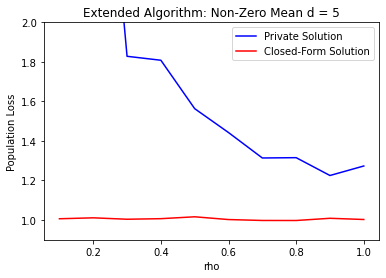

In [85]:
n_values = range(1000,3001,250)
d = 5
iters = 50
mu = 10
privacy_budget = 0.5
nonzero_mean_algo_losses(n_values, d, iters, privacy_budget, lin_reg_interactive.loss, mu)